
# My Pure Pix2Pix Implementation
****

## General Presets

In [2]:
""" Import Packages """

# Numerical Operations
import random
import numpy as np
# Reading/Writing/Cleaning Data
import pandas as pd
from PIL import Image
import os
import gc
# For Progress Bar
from tqdm.auto import tqdm
# For Display
%matplotlib inline
import matplotlib.pyplot as plt
import wandb as wb
# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset, random_split
from torchvision.datasets import DatasetFolder, VisionDataset
# my_utilities
import my_utilities


In [3]:
""" For Display """

plt.style.use(r'C:\Users\chael\.matplotlib\violet.mplstyle')
wb.init(project="pure_pix2pix", name="run0")


wandb: Currently logged in as: cullencatniss. Use `wandb login --relogin` to force relogin


In [4]:
""" For Auto-reload Modules"""

%reload_ext autoreload
%autoreload 2

In [5]:
""" Assure Reproducibility """

seed = 29
my_utilities.assure_reproduce(seed)

## Configurations

In [6]:
""" Path & Device"""

dataset_name = 'facades/'
task_name = 'facades_pix2pix/'
data_dir, checkpoints_dir, results_dir = 'datasets/' + dataset_name, 'checkpoints/' + task_name, 'results/' + task_name
device = my_utilities.register_device()

In [7]:
""" Loading & saving Rules """

# 'data_load_threads' =
# 'epoch_load' =
model_load = 'by iters.'  # | by_epochs
results_save = 5000  # frequency of saving latest result (by iters.)
checkpoints_save = 5  # frequency of saving latest checkpoints (by epochs)
model_save = 'by iters.'  # | by_epochs

In [8]:
""" Preprocessing Rules """

preproc_train = {
	'trans': 'scale & crop',  # | crop | scale width | scale width & crop | none
	'scale_size': 286,  # !!! in TEST TIME set to crop_size !!!
	'crop_size': 256,
	'flip': False  # whether to flip images in augmentation
}
preproc_test = {
	'trans': preproc_train['trans'],
	'scale_size': preproc_train['crop_size'],
	'crop_size': preproc_train['crop_size'],
	'flip': preproc_train['flip']
}

In [9]:
""" Model """

model_name = 'pix2pix'
translate_dirct = 'facades->photo'  # | 'photo->facades'

hyper_params = {
	# ======= network architectures =======
	'G_arch': 'U-net256',  # | U-net128
	'D_arch': 'PatchGAN',  # (for experiments in the paper) | PixelGAN | StdCNN
	# 'G_layers':
	'D_layers': 3,
	'in_chan': 3,
	'out_chan': 3,
	'G_fil_num': 64,  # num. of filters in G's first conv. layer
	'D_fil_num': 64,  # num. of filters in D's first conv. layer
	'batch_size': 32,
	'norm_type': 'instance',  # (for experiments in the paper) | batch | none
	'G_dropout': True,
	'D_dropout': False,  # no dropout for G in the paper
	# ============== training ==============
	# 'init_type':
	'init_scaler': 0.02,  # scaling factor for weight initialization
	'shuffle_batch': True,
	'continue_train': True,  # whether to load latest model
	'loss_mode': 'vanilla GAN',  # | lsgan | wgangp
	'L1_lambda': 100,  # L1's scaler (add L1 to GAN-loss according to the paper)
	'beta1': 0.5,  # momentum for Adam (0.9?)
	# 'beta2': (?)
	'lr': 0.0002,  # initial learning rate for Adam (0.001?)
	'lr_dec_mode': 'linear',  # | step | plateau | cosine
	'lr_dec_iters': 50,  # multiply by a gamma every lr_decay_iters iterations
	'init_lr_epochs': 100,
	'decay_lr_epochs': 100,  # linear decay to 0
}

In [10]:
wb.config.update({'translate_dirct': translate_dirct, **preproc_train, **hyper_params})
my_utilities.print_config(device, model_load, model_save, model_name, translate_dirct,
                          {**preproc_train, **hyper_params})

============CONFIGURATIONS============
Device = cuda
Model is loaded by iters.
Model is saved by iters.
Model = pix2pix
Translation Dirct. = facades->photo
--------------------------------------
Transforms Opt. = scale & crop
Img. Scale Size = 286
Img. Crop Size = 256
Flipped = False
--------------------------------------
G's Arch. = U-net256
D's Arch. = PatchGAN
num. of D's layers = 3
num. of Input's Channels = 3
num. of Output's Channels = 3
--------------------------------------
Batch Size = 32
Normalization = instance
G's Dropout = True
D's Dropout = False
--------------------------------------
Loss Mode = vanilla GAN
L1's Lambda = 100
Beta1 = 0.5
Initial Learning-rate = 0.0002
Decay Mode = linear


## Data Preparation

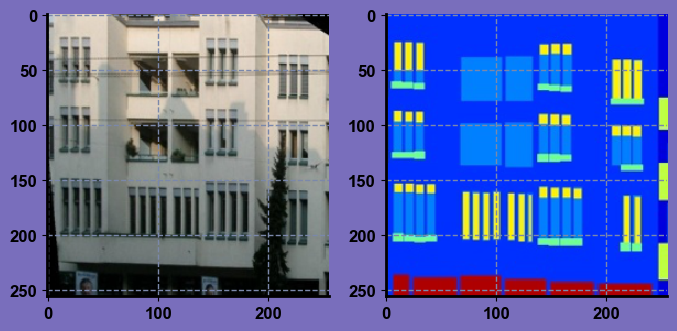

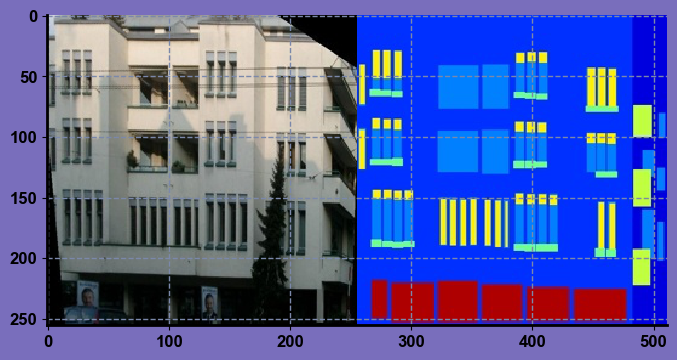

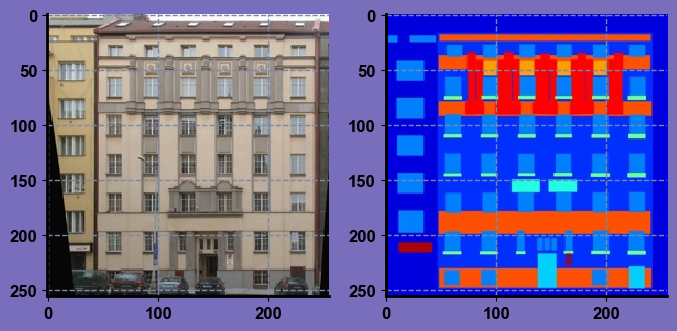

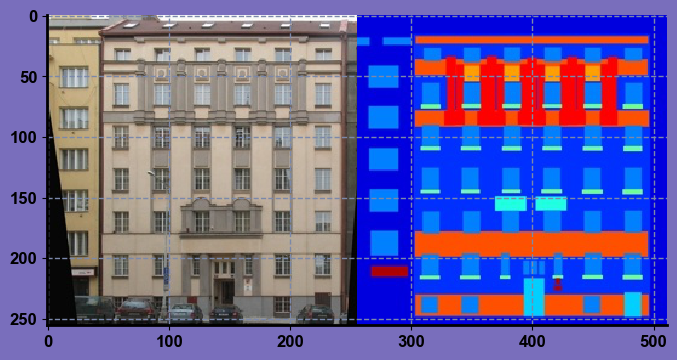

In [17]:
""" Create Dataset (includes split & transforms) """

raw_train_set = my_utilities.read_img(data_dir, 'train')
raw_test_set = my_utilities.read_img(data_dir, 'test')
train_set = my_utilities.Imageset(preproc_train, raw_train_set)
train_set.check_preproc(0)
test_set = my_utilities.Imageset(preproc_test, raw_test_set)
test_set.check_preproc(0)

In [18]:
""" Load data to batches """

train_batches = DataLoader(train_set, hyper_params['batch_size'], hyper_params['shuffle_batch'], pin_memory=True)
test_batches = DataLoader(test_set, hyper_params['batch_size'], hyper_params['shuffle_batch'], pin_memory=True)

## Build Model

### --- Generator ---

In [73]:
""" Define U-net's arch. """


class Unet(nn.Module):
	def __init__(self, img_size=256, in_chan=3, out_chan=3, fst_filters=64, norm='batch', dropout=True):
		"""
		:param img_size: width (or height) of input img.
		:param in_chan: number of input channels
		:param out_chan: number of output channels
		:param fst_filters: number of filters in the first conv.
		:param norm: type of conv.'s normalization
		:param dropout: whether to use dropout
		"""
		super().__init__()
		self.encoder = []  # a list of layers in encoder
		self.decoder = []  # a list of layers in decoder
		self.N = img_size
		self.in_chan = in_chan
		self.out_chan = out_chan
		self.fst_filter = fst_filters
		norm_opt = {'batch': nn.BatchNorm2d, 'instance': nn.InstanceNorm2d}
		self.norm = norm_opt[norm]
		self.dropout = dropout
		self.drop_rate = 0.5
		self.leak_slope = 0.2
		self.F, self.S, self.P = 4, 2, 1  # filter_size, padding_width, step_size
		self.layers_num = 0

	def check_layers(self):
		while self.N != 1:
			self.N = (self.N - self.F + 2 * self.P) / self.S + 1  # simulate the change of img. size
			assert (self.N - int(self.N) == 0)
			self.layers_num = self.layers_num + 1
		print("Layers num. = " + str(self.layers_num))

	def pile_encoder(self):
		n = len(self.encoder)
		if n < self.layers_num:
			# set in|out channels
			if n == 0:
				layer_in_chan, layer_out_chan = self.in_chan, self.fst_filter
			elif n < 4:
				layer_in_chan, layer_out_chan = self.fst_filter * (2 ** (n - 1)), self.fst_filter * (2 ** n)
			else:
				layer_in_chan, layer_out_chan = self.fst_filter * 8, self.fst_filter * 8
			# construct layer
			layer = []
			layer += [nn.LeakyReLU(self.leak_slope, inplace=True)] if n != 0 else []
			layer += [
				nn.Conv2d(in_channels=layer_in_chan, out_channels=layer_out_chan, kernel_size=self.F, stride=self.S,
				          padding=self.P)]
			layer += [self.norm(layer_out_chan)] if n != 0 and n != self.layers_num - 1 else []
			# add layer
			self.encoder.append(nn.Sequential(*layer))
			print("En-layer " + str(n) + " added: ", layer_in_chan, "=>",
			      layer_out_chan)  # layer_no is the index in encoder[]
			# add another
			self.pile_encoder()

		return  # if len(self.encoder)==self.layers_num then the encoder is already intact

	def pile_decoder(self):  # pile decoder reversely for convenience
		n = len(self.decoder)
		if n < self.layers_num:
			# set in|out channels
			if n == 0:
				layer_in_chan, layer_out_chan = 2 * self.fst_filter, self.out_chan
			elif n < 4:
				layer_in_chan, layer_out_chan = 2 * (self.fst_filter * (2 ** n)), self.fst_filter * (2 ** (n - 1))
			elif n == self.layers_num - 1:
				layer_in_chan, layer_out_chan = self.fst_filter * 8, self.fst_filter * 8
			else:
				layer_in_chan, layer_out_chan = 2 * (self.fst_filter * 8), self.fst_filter * 8
			# construct layer
			layer = []
			layer += [nn.ReLU(inplace=True)]
			layer += [nn.ConvTranspose2d(in_channels=layer_in_chan, out_channels=layer_out_chan, kernel_size=self.F,
			                             stride=self.S, padding=self.P)]
			layer += [self.norm(layer_out_chan)] if n != 0 else []
			layer += [nn.Dropout(0.5)] if n != 0 and self.dropout == True else []
			layer += [nn.Tanh()] if n == 0 else []
			# add layer
			self.decoder.append(nn.Sequential(*layer))
			print("De-layer " + str(n) + " added: ", layer_in_chan, "=>", layer_out_chan)
			# add another
			self.pile_decoder()

		return  # if len(self.decoder)==self.layers_num then the reversed decoder is already intact

	def en_forward(self, x, i):
		self.encoder[i] = self.encoder[i](x) if i == 0 else self.encoder[i](self.en_forward(x, i - 1))
		# (reuse self.encoder for inner results of encoder)
		print("En-layer " + str(i) + " done: ", self.encoder[i].size())
		return self.encoder[i]

	def de_forward(self, x, i):
		res = self.decoder[i](x) if i == self.layers_num - 1 else self.decoder[i](self.de_forward(x, i + 1))
		if i != 0: res = torch.cat([res, self.encoder[i - 1]], dim=0)
		print("De-layer " + str(i) + " done: ", res.size())
		return res

	def forward(self, x):
		self.check_layers()
		print('=====================================================')
		self.pile_encoder()
		print('-----------------------------------------------------')
		self.pile_decoder()
		print('=====================================================')
		latent = self.en_forward(x, self.layers_num - 1)
		print('-----------------------------------------------------')
		y = self.de_forward(latent, 0)
		return y


""" Create Generator instance """
G = Unet(
	preproc_train['crop_size'],
	hyper_params['in_chan'], hyper_params['out_chan'],
	hyper_params['G_fil_num'], hyper_params['norm_type'], hyper_params['G_dropout']
)

""" Test implementation """
photo, _ = train_set.__getitem__(0)
fake_facade = G.forward(photo)

Layers num. = 8
En-layer 0 added:  3 => 64
En-layer 1 added:  64 => 128
En-layer 2 added:  128 => 256
En-layer 3 added:  256 => 512
En-layer 4 added:  512 => 512
En-layer 5 added:  512 => 512
En-layer 6 added:  512 => 512
En-layer 7 added:  512 => 512
-----------------------------------------------------
De-layer 0 added:  128 => 3
De-layer 1 added:  256 => 64
De-layer 2 added:  512 => 128
De-layer 3 added:  1024 => 256
De-layer 4 added:  1024 => 512
De-layer 5 added:  1024 => 512
De-layer 6 added:  1024 => 512
De-layer 7 added:  512 => 512
En-layer 0 done:  torch.Size([64, 128, 128])
En-layer 1 done:  torch.Size([128, 64, 64])
En-layer 2 done:  torch.Size([256, 32, 32])
En-layer 3 done:  torch.Size([512, 16, 16])
En-layer 4 done:  torch.Size([512, 8, 8])
En-layer 5 done:  torch.Size([512, 4, 4])
En-layer 6 done:  torch.Size([512, 2, 2])
En-layer 7 done:  torch.Size([512, 1, 1])
-----------------------------------------------------
De-layer 7 done:  torch.Size([1024, 2, 2])
De-layer 6 

### --- Discriminator ---

In [74]:
""" Define PatchGAN's arch. """


class PatchGAN(nn.Module):
	def __init__(self, img_size=256, in_chan=3, out_chan=3, fst_filters=64, norm='batch'):
		"""
		:param img_size: width (or height) of input img.
		:param in_chan: number of input channels
		:param out_chan: number of output channels
		:param fst_filters: number of filters in the first conv.
		:param norm: type of conv.'s normalization
		"""
		super().__init__()
		self.cnn = []
		self.N = img_size
		self.in_chan = in_chan
		self.out_chan = out_chan
		self.fst_filter = fst_filters
		norm_opt = {'batch': nn.BatchNorm2d, 'instance': nn.InstanceNorm2d}
		self.norm = norm_opt[norm]
		self.F, self.S, self.SS, self.P = 4, 2, 1, 1  # filter_size, padding_width, step_size
		self.leak_slope = 0.2
		self.layers_num = 5  # 70*70 per Patch of input img.

	def pile_cnn(self):
		n = len(self.cnn)
		if n < self.layers_num:
			# set in|out channels
			layer_in_chan = self.in_chan if n == 0 else self.fst_filter * (2 ** (n - 1))
			layer_out_chan = self.fst_filter * (2 ** n) if n != 4 else 1
			step_size = self.S if n < 3 else self.SS
			# construct layer
			layer = []
			layer += [nn.Conv2d(layer_in_chan, layer_out_chan, self.F, step_size, self.P)]
			layer += [self.norm(layer_out_chan)] if n != 0 and n != 4 else []
			layer += [nn.LeakyReLU(0.2, inplace=True)] if n != 4 else []
			# add layer
			self.cnn.append(nn.Sequential(*layer))
			print("C-layer " + str(n) + " added: ", layer_in_chan, "=>", layer_out_chan)
			# add another
			self.pile_cnn()

		return  # if len(self.cnn)==self.layers_num then the patchGAN is already intact

	def conv_forward(self, x, i):
		res = self.cnn[i](x) if i == 0 else self.cnn[i](self.conv_forward(x, i - 1))
		print("C-layer " + str(i) + " done: ", res.size())
		return res

	def forward(self, x):
		self.pile_cnn()
		print('=====================================================')
		patch_scores = self.conv_forward(x, self.layers_num - 1)
		patch_scores = nn.functional.sigmoid(patch_scores)
		print('-----------------------------------------------------')
		print("Sigmoid done: ", patch_scores.size())
		return patch_scores


""" Create Generator instance """
D = PatchGAN(
	preproc_train['crop_size'],
	hyper_params['in_chan'], hyper_params['out_chan'],
	hyper_params['D_fil_num'], hyper_params['norm_type']
)

""" Test implementation """
photo, _ = train_set.__getitem__(0)
patch_scores = D.forward(photo)

C-layer 0 added:  3 => 64
C-layer 1 added:  64 => 128
C-layer 2 added:  128 => 256
C-layer 3 added:  256 => 512
C-layer 4 added:  512 => 1
C-layer 0 done:  torch.Size([64, 128, 128])
C-layer 1 done:  torch.Size([128, 64, 64])
C-layer 2 done:  torch.Size([256, 32, 32])
C-layer 3 done:  torch.Size([512, 31, 31])
C-layer 4 done:  torch.Size([1, 30, 30])
-----------------------------------------------------
Sigmoid done:  torch.Size([1, 30, 30])


## Train Model

### --- Train Discriminator ---

In [ ]:
""" Define training loop for D. """


def D_train